In [1]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
directory = "data/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [3]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, validation_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [4]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [5]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(validation_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

In [6]:
len(glob("data/train/*/*")), len(glob("data/validation/*/*"))

(1575, 175)

## **Create a custom dataset and a dataloader**


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

C:\MinGW\ipykernel_14276\383158894.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [10]:
class ThaiDigitDataset(Dataset):
    def __init__(self, img_dir: str, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(p, Path(p).parent.name) for p in glob(op.join(img_dir, "*", "*"))]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image, label = self.img_labels[idx]
        label = int(label)
        image = Image.open(image)
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [11]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=transform)

In [12]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**


In [14]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10),
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs


In [15]:
n_epoch = 100

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29759 train acc 0.12698 val loss 2.28313 val acc 0.21143
--------------------------------------------------------------------------------
Epochs 2   train loss 2.26512 train acc 0.24317 val loss 2.25405 val acc 0.28571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.22655 train acc 0.30857 val loss 2.21201 val acc 0.31429
--------------------------------------------------------------------------------
Epochs 4   train loss 2.17687 train acc 0.33778 val loss 2.15884 val acc 0.36000
--------------------------------------------------------------------------------
Epochs 5   train loss 2.11373 train acc 0.37524 val loss 2.09437 val acc 0.37143
--------------------------------------------------------------------------------
Epochs 6   train loss 2.03796 train acc 0.40889 val loss 2.01159 val acc 0.45143
----------------------------

In [16]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

C:\MinGW\ipykernel_14276\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


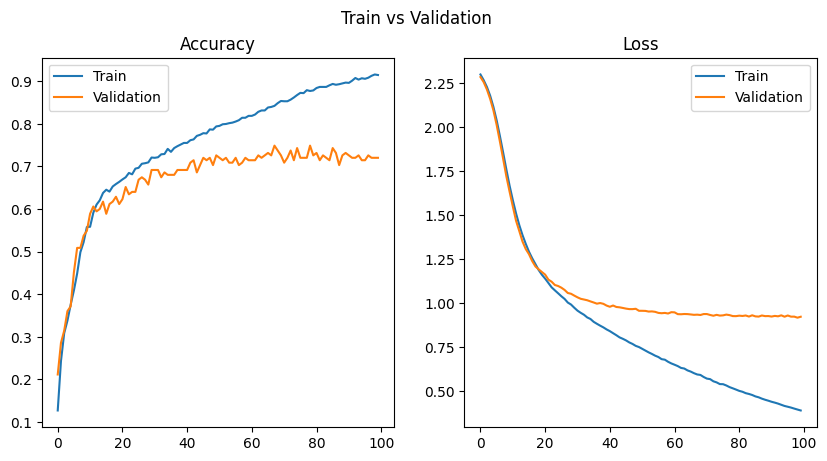

In [17]:
plot_graph(net_history)

We can observe "overfitting" as the model learns to predict the training set well but perform worse in validation set


## **Evaluate the model**


In [18]:
# Create evaluation function for the model
def evaluate(val_dir, model):
    model.eval()
    paths = glob(op.join(val_dir, "*", "*"))
    predictions = []
    for idx, path in enumerate(paths):
        img = 1 - transform(Image.open(path))
        pred = model(img)
        predictions.append({
            "path": path,
            "prediction": int(pred.argmax(dim=1).item()),
            "label": int(Path(path).parent.name)
        })

    results = pd.DataFrame(predictions)
    # Calculate accuracy
    accuracy = (results.prediction == results.label).sum() / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [19]:
pred_df = evaluate("data/validation/", net)
pred_df.head(3)

Accuracy: 72.00%


,path,prediction,label
0,data/validation\0\21_0cce64ca-f6e6-4b77-99ec-f...,0,0
1,data/validation\0\23_6db9fc09-96ed-44a9-8052-c...,0,0
2,data/validation\0\24_69799b34-de22-4866-b1cd-d...,0,0


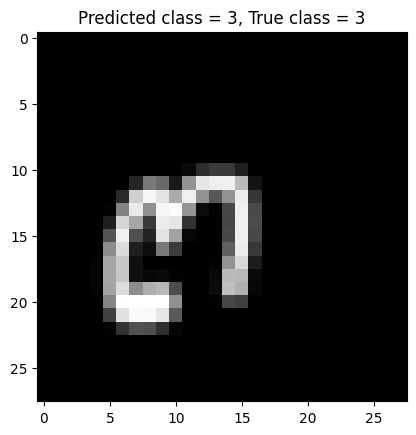

In [20]:
# Show some random images with their predicted number
sample_path = glob("data/validation/*/*.png")[50]
img = Image.open(sample_path)
img = (1 - transform(img)).squeeze(0)
pred = net(img)
pred = int(pred.argmax(dim=1))
true_class = Path(sample_path).parent.name

plt.title("Predicted class = {}, True class = {}".format(pred, true_class))
plt.imshow(img, cmap="gray")
plt.show()

## **Train neural netowrk model with more layers**


In [23]:
# TODO: Create neural network with more layers
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [24]:
n_epochs = 100

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30345 train acc 0.10032 val loss 2.30363 val acc 0.09143
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30220 train acc 0.09714 val loss 2.30291 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30093 train acc 0.11048 val loss 2.30214 val acc 0.11429
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29982 train acc 0.13460 val loss 2.30134 val acc 0.13714
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29854 train acc 0.12952 val loss 2.30042 val acc 0.14286
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29723 train acc 0.16762 val loss 2.29927 val acc 0.14857
----------------------------

In [25]:
pred_df = evaluate("data/validation/", more_layers_model)
pred_df.head(3)

Accuracy: 73.71%


,path,prediction,label
0,data/validation\0\21_0cce64ca-f6e6-4b77-99ec-f...,0,0
1,data/validation\0\23_6db9fc09-96ed-44a9-8052-c...,0,0
2,data/validation\0\24_69799b34-de22-4866-b1cd-d...,0,0


C:\MinGW\ipykernel_14276\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


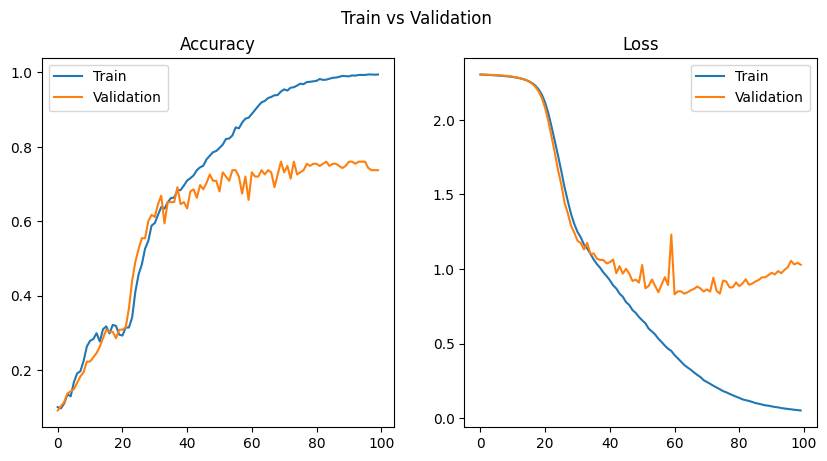

In [26]:
plot_graph(more_layers_model_history)

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .


## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting. Here, we can train the model for more epochs to observe the loss curve.


In [27]:
# TODO: Add Dropout layer to the previous neural network
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        self.dropout = nn.Dropout(0.1) # prob of dropout, default = 0.5

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [28]:
n_epochs = 100
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

dropout_model, dropout_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30431 train acc 0.10540 val loss 2.30156 val acc 0.13714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30312 train acc 0.09968 val loss 2.30092 val acc 0.14286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30184 train acc 0.11302 val loss 2.30035 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30030 train acc 0.11937 val loss 2.29958 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29920 train acc 0.12889 val loss 2.29886 val acc 0.11429
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29800 train acc 0.12952 val loss 2.29783 val acc 0.10857
----------------------------

In [30]:
pred_df = evaluate("data/validation/", dropout_model)
pred_df.head(3)

Accuracy: 80.00%


,path,prediction,label
0,data/validation\0\21_0cce64ca-f6e6-4b77-99ec-f...,0,0
1,data/validation\0\23_6db9fc09-96ed-44a9-8052-c...,0,0
2,data/validation\0\24_69799b34-de22-4866-b1cd-d...,0,0


C:\MinGW\ipykernel_14276\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


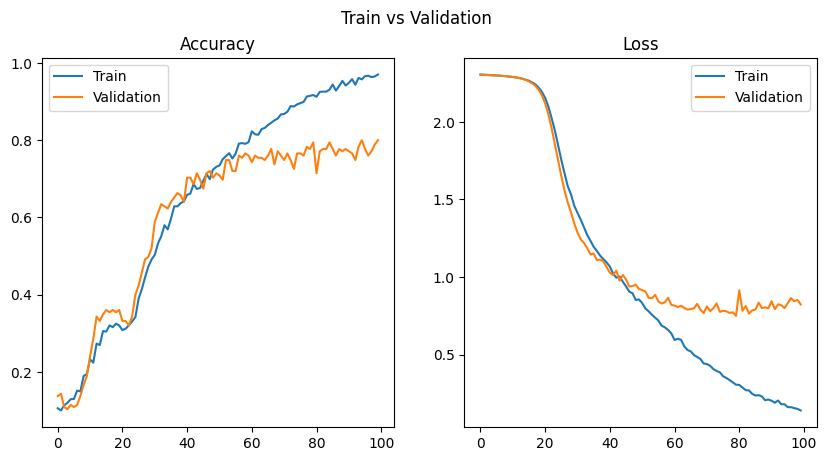

In [31]:
plot_graph(dropout_model_history)

Now the gap between the training accuracy and validation accuracy is smaller than before.


## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.


In [36]:
# TODO: Add image augmentation in `train_transform`

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    # add RandomAffine transform here
    transforms.RandomAffine(degrees=(-10,10), translate=(0.0,0.1), scale=(0.95, 1.1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

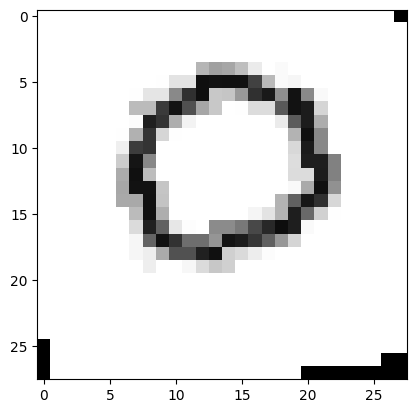

In [38]:
path = glob("data/thai-handwritten-dataset/*/*")[30]
img = Image.open(path)

# Transform image using `train_transform`
transformed_img =  train_transform(img).squeeze(0)

plt.imshow(transformed_img, cmap="gray")
plt.show()

In [39]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=train_transform) # augment in train dataset
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=val_transform) # no augment in val dataset

In [40]:
train_dataloader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

In [41]:
# Let's train the model with augmented data
n_epochs = 150 # increase epochs a little bit due to more various of dataset
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30429 train acc 0.09905 val loss 2.30408 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30287 train acc 0.09968 val loss 2.30313 val acc 0.11429
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30159 train acc 0.10603 val loss 2.30225 val acc 0.13143
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30125 train acc 0.11302 val loss 2.30132 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29945 train acc 0.10730 val loss 2.30031 val acc 0.11429
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29862 train acc 0.11873 val loss 2.29895 val acc 0.10286
----------------------------

In [42]:
# Evaluate the new model with old dataset.
pred_df = evaluate("data/validation/", augmented_model)
pred_df.head(3)

Accuracy: 87.43%


,path,prediction,label
0,data/validation\0\21_0cce64ca-f6e6-4b77-99ec-f...,0,0
1,data/validation\0\23_6db9fc09-96ed-44a9-8052-c...,0,0
2,data/validation\0\24_69799b34-de22-4866-b1cd-d...,0,0


C:\MinGW\ipykernel_14276\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


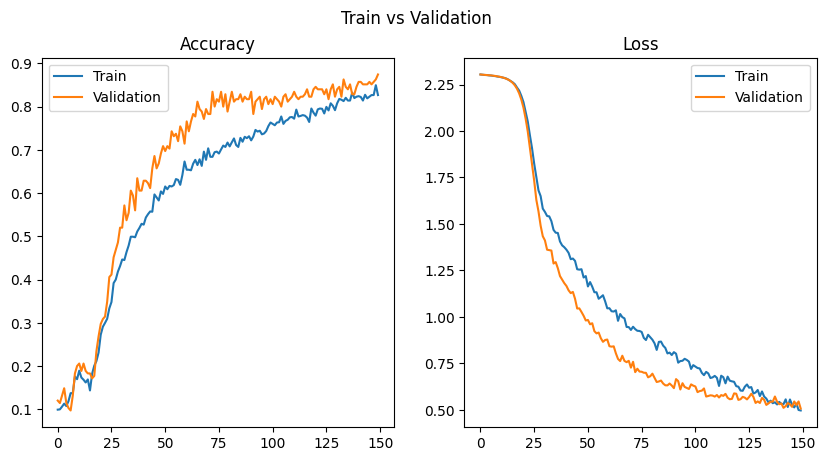

In [43]:
plot_graph(augmented_model_history)

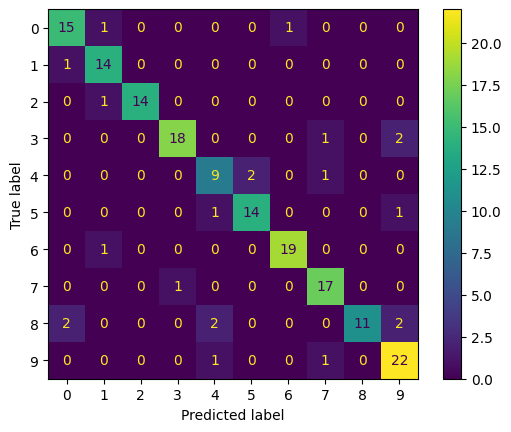

In [44]:
# Confusion matrix
cm = confusion_matrix(pred_df.label, pred_df.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()

## save model


In [46]:
save_path = "model/thai_digit_pth"
torch.save(net.state_dict(), save_path)